<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 11567 entries, 389279 to 13114110866
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   y             11567 non-null  float64 
 1   x             11567 non-null  float64 
 2   street_count  11567 non-null  int64   
 3   junction      91 non-null     object  
 4   ref           88 non-null     object  
 5   highway       1471 non-null   object  
 6   railway       7 non-null      object  
 7   geometry      11567 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 813.3+ KB
Node info: None
<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 14472 entries, (np.int64(389279), np.int64(1396858852), np.int64(0)) to (np.int64(13042760002), np.int64(13042760003), np.int64(0))
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      14472 non-null  object  

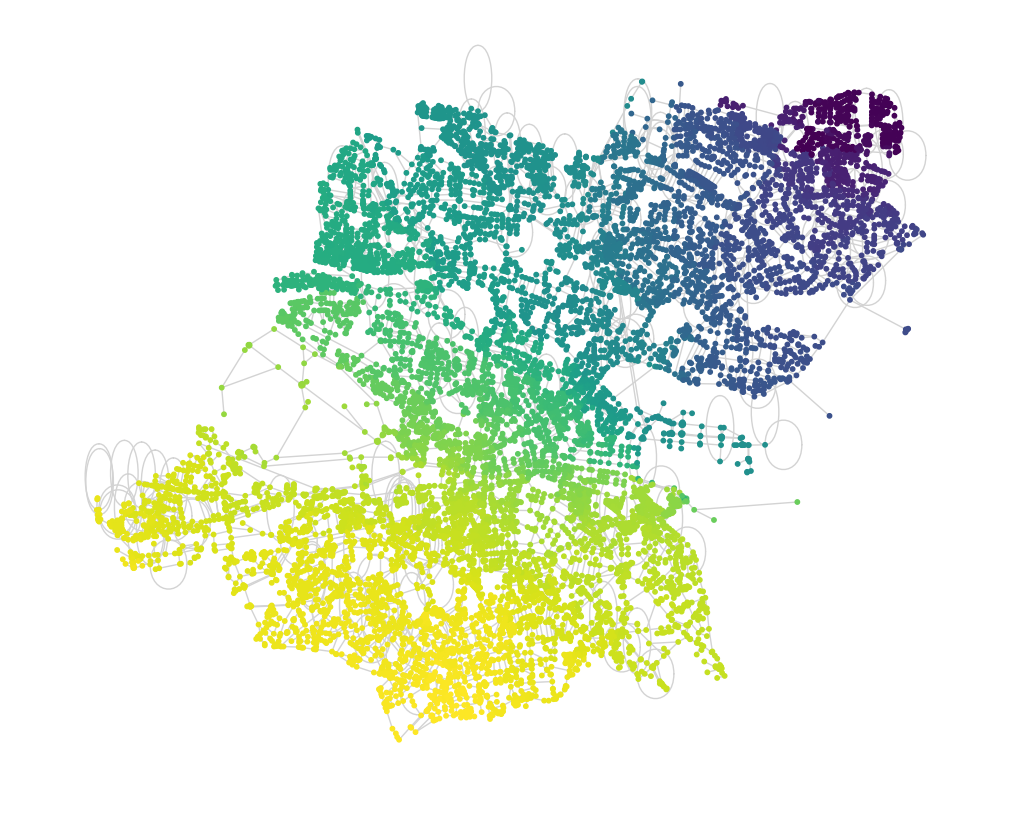

In [5]:
import osmnx as ox
import networkx as nx
import folium
import numpy as np
import matplotlib.pyplot as plt

# Download and prepare the graph
place_name = "Dublin City, Ireland"
G = ox.graph.graph_from_place(place_name, network_type="drive")
G = G.to_undirected()

#G = ox.simplification.consolidate_intersections(
#        G,
#        tolerance=0.0002,
#        rebuild_graph=True,
#        dead_ends=False 
#    )

# Convert graph to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

print(f'Node info: {nodes_gdf.info()}')
print(f'Edge info: {edges_gdf.info()}')

nodelist = list(G.nodes())
A = nx.to_numpy_array(G, weight="length")  # or weight="lanes"
np.save("adj_matrix", A)


# Calculate map center
center_lat = (nodes_gdf.y.min() + nodes_gdf.y.max()) / 2
center_lon = (nodes_gdf.x.min() + nodes_gdf.x.max()) / 2

# Create the map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=12,
    tiles='OpenStreetMap'
)

# Add edges to the map
for idx, row in edges_gdf.iterrows():
    if row.geometry is not None:

        # Convert coordinates for Folium [lat, lon] format
        coords = [[point[1], point[0]] for point in row.geometry.coords]
        
        # Create popup with street information
        popup_text = f"Street: {row.get('name', 'Unnamed')}<br>Type: {row.get('highway', 'Unknown')}<br>Reversed: {row.get('reversed', 'Unknown')}"


        if idx[0] < 20:
            print(f'Num lanes : {row.lanes}')
            print(f'Type : {row.highway}')
            try:
                folium.PolyLine(
            locations=coords,
            color='orange',
            weight=2,
            opacity=0.7,
            popup=folium.Popup(popup_text, max_width=200)
        ).add_to(m)
            except:        
                folium.PolyLine(
                    locations=coords,
                    color='blue',
                    weight=2,
                    opacity=0.7,
                    popup=folium.Popup(popup_text, max_width=200)
                ).add_to(m)

        else:
            folium.PolyLine(
            locations=coords,
            color='blue',
            weight=2,
            opacity=0.7,
            popup=folium.Popup(popup_text, max_width=200)
        ).add_to(m)

# Add some major intersections as markers
major_intersections = [node for node, degree in G.degree() if degree >= 8]
for node_id in major_intersections:
    node_data = nodes_gdf.loc[node_id]
    folium.CircleMarker(
        location=[node_data.y, node_data.x],
        radius=4,
        popup=f"Major Intersection<br>Node: {node_id}<br>Connections: {G.degree(node_id)}",
        color='red',
        fillColor='red',
        fillOpacity=0.8
    ).add_to(m)


nodes_gdf.to_csv("node_data.csv")
edges_gdf.to_csv("edges_data.csv")

# Save the map
m.save("dublin_interactive_osmnx.html")
print("Interactive map saved as 'dublin_interactive_osmnx.html'")

# Display basic graph info
print(f"Graph contains {len(G.nodes)} nodes and {len(G.edges)} edges")
# print(f"Found {len(major_intersections)} major intersections (degree >= 4)")

degrees = np.sum(A, axis=1)
D = np.diag(degrees)
L = D - A
eigvals, eigvecs = np.linalg.eigh(L)
#eigenvalues (connectivity, bottlenecks),eigenvectors (natural partitions / “veins” of travel)

# pick second eigenvector
fiedler = eigvecs[:,1]

plt.figure(figsize=(10,8))
nx.draw(
    G, 
    pos={n:(nodes_gdf.loc[n].x, nodes_gdf.loc[n].y) for n in G.nodes()}, 
    node_color=fiedler, 
    cmap=plt.cm.viridis, 
    node_size=10, 
    edge_color="lightgrey"
)
plt.show()

# map back to node IDs
fiedler_dict = {node: fiedler[i] for i, node in enumerate(nodelist)}



Text(0.5, 1.0, 'Spectral partition (Fiedler vector) – Dublin road network')

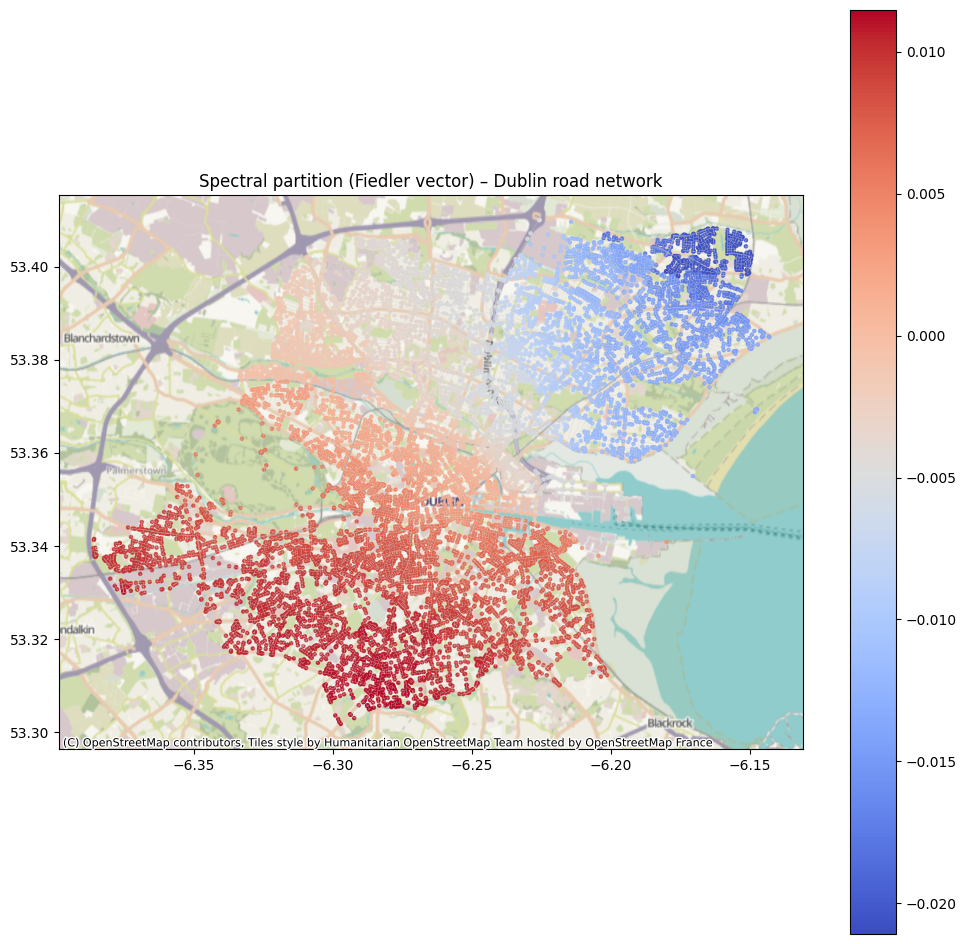

In [6]:
import contextily as ctx
ax = nodes_gdf.plot(
    column=fiedler, cmap="coolwarm", markersize=5, alpha=0.8,
    legend=True, figsize=(12, 12)
)
edges_gdf.plot(ax=ax, color="lightgrey", linewidth=0.3, alpha=0.7)
ctx.add_basemap(ax, crs=nodes_gdf.crs.to_string())
plt.title("Spectral partition (Fiedler vector) – Dublin road network")

c:\Users\user1\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


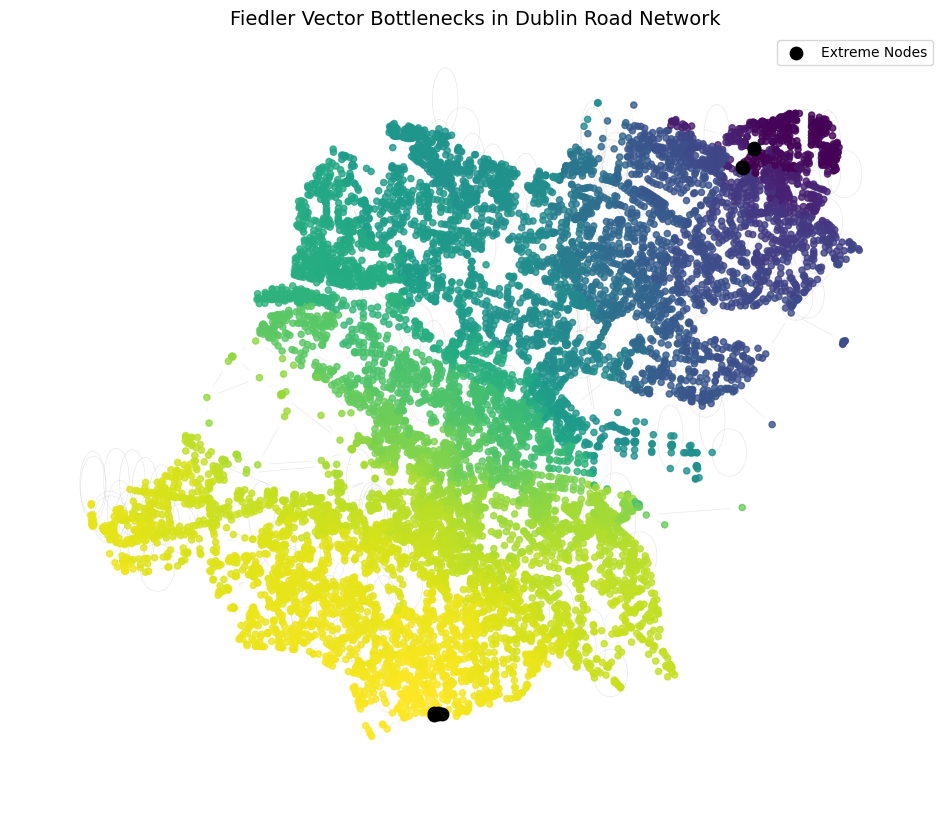

In [7]:
# 1. Compute differences across edges
edge_diffs = []
for u, v in G.edges():
    diff = abs(fiedler_dict[u] - fiedler_dict[v])
    edge_diffs.append((u, v, diff))

# 2. Select top-k bottleneck edges
k = 20
critical_edges = sorted(edge_diffs, key=lambda x: x[2], reverse=True)[:k]

# 3. Select extreme nodes (anchors of communities)
critical_nodes = np.argsort(fiedler)[:5].tolist() + np.argsort(fiedler)[-5:].tolist()

critical_nodes = [nodelist[i] for i in np.argsort(fiedler)[:5]] \
               + [nodelist[i] for i in np.argsort(fiedler)[-5:]]

# 4. Build positions from coordinates
pos = {n: (nodes_gdf.loc[n].x, nodes_gdf.loc[n].y) for n in G.nodes()}

# 5. Plot
plt.figure(figsize=(12, 10))

# draw all edges (light grey)
nx.draw_networkx_edges(G, pos, edge_color="lightgrey", width=0.5, alpha=0.5)

# draw bottleneck edges (red, thicker)
nx.draw_networkx_edges(
    G, pos,
    edgelist=[(u, v) for u, v, _ in critical_edges],
    edge_color="red", width=2.5, alpha=0.8, label="Bottlenecks"
)

# draw all nodes with Fiedler colouring
nx.draw_networkx_nodes(
    G, pos,
    node_color=fiedler,
    cmap=plt.cm.viridis,
    node_size=20,
    alpha=0.8
)

# highlight critical nodes (extremes of Fiedler vector)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=critical_nodes,
    node_color="black",
    node_size=80,
    label="Extreme Nodes"
)

plt.title("Fiedler Vector Bottlenecks in Dublin Road Network", fontsize=14)
plt.axis("off")
plt.legend()
plt.show()

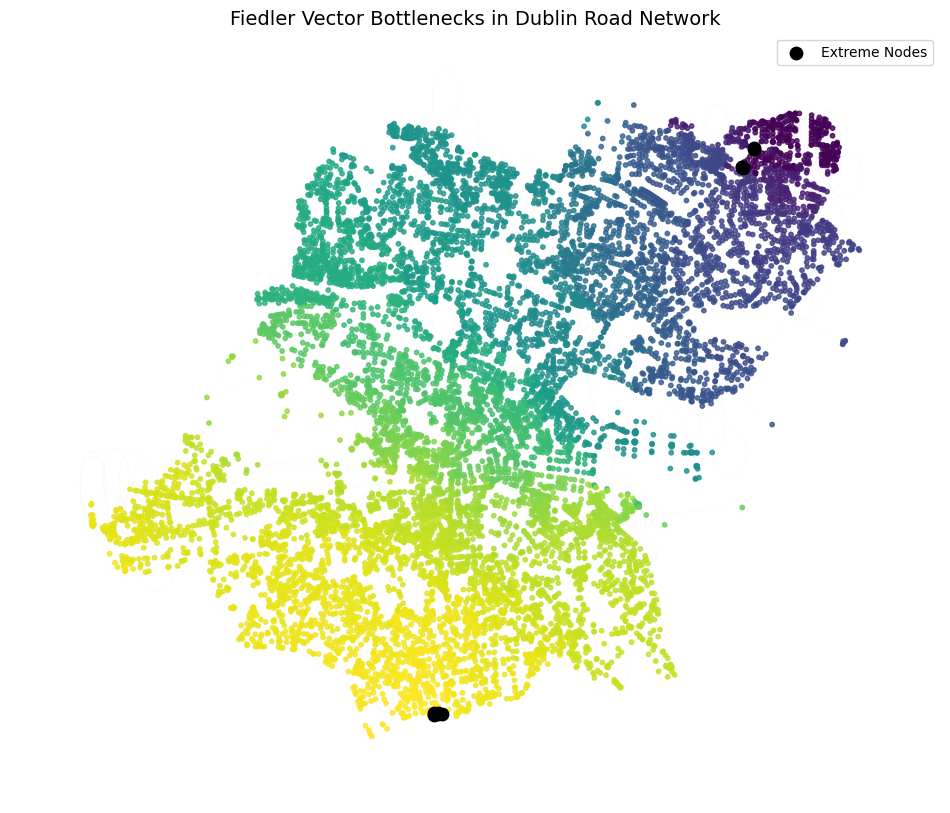

In [8]:
plt.figure(figsize=(12, 10))

# 1. Draw all edges (light grey, very thin)
nx.draw_networkx_edges(
    G, pos,
    edge_color="lightgrey",
    width=0.2,
    alpha=0.3
)

# 2. Draw bottleneck edges (bold red)
nx.draw_networkx_edges(
    G, pos,
    edgelist=[(u, v) for u, v, _ in critical_edges],
    edge_color="red",
    width=3,
    alpha=0.9,
    label="Bottlenecks"
)

# 3. Draw all nodes with Fiedler coloring
nx.draw_networkx_nodes(
    G, pos,
    node_color=[fiedler_dict[n] for n in G.nodes()],
    cmap=plt.cm.viridis,
    node_size=10,
    alpha=0.8
)

# 4. Highlight extreme nodes (bigger black markers)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=critical_nodes,
    node_color="black",
    node_size=80,
    label="Extreme Nodes"
)

plt.title("Fiedler Vector Bottlenecks in Dublin Road Network", fontsize=14)
plt.axis("off")
plt.legend()
plt.show()

C:\Users\user1\AppData\Local\Temp\ipykernel_12672\3401141873.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")


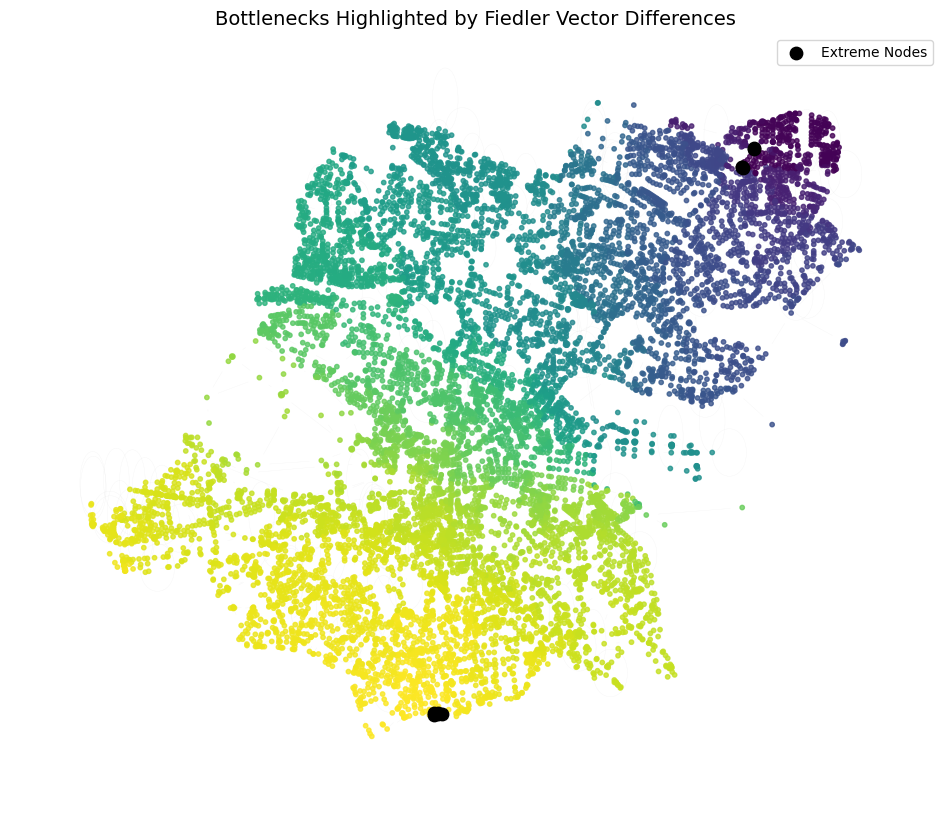

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Normalize bottleneck weights
diffs = [d for _, _, d in critical_edges]
norm = colors.Normalize(vmin=min(diffs), vmax=max(diffs))
cmap = cm.get_cmap("Reds")

# Plot
plt.figure(figsize=(12, 10))

# 1. All background edges (light grey)
nx.draw_networkx_edges(
    G, pos, edge_color="lightgrey", width=0.2, alpha=0.3
)

# 2. Bottleneck edges colored by ΔFiedler
for u, v, diff in critical_edges:
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color=[cmap(norm(diff))],
        width=3,
        alpha=0.9
    )

# 3. Nodes (colored by Fiedler value)
nx.draw_networkx_nodes(
    G, pos,
    node_color=[fiedler_dict[n] for n in G.nodes()],
    cmap=plt.cm.viridis,
    node_size=10,
    alpha=0.8
)

# 4. Extreme nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=critical_nodes,
    node_color="black",
    node_size=80,
    label="Extreme Nodes"
)

plt.title("Bottlenecks Highlighted by Fiedler Vector Differences", fontsize=14)
plt.axis("off")
plt.legend()
plt.show()
